In [67]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import striplog

from coremdlr import datasets, viz, config

In [68]:
# Image tick args you can change
img_kwargs = {
    'name' : 'Image',
    'major_tick_size' : 16,
    'minor_tick_size' : 8,
    'major_precision' : 0.1,
    'major_format_str' : '{:.1f}',
    'minor_precision' : 0.01,
    'minor_format_str' : '{:.2f}'
}

class_to_component = {
    0 : config.strip_config.facies['s'],
    1 : config.strip_config.facies['is'],
    2 : config.strip_config.facies['ih'],
    3 : config.strip_config.facies['os'],
    4 : config.strip_config.facies['sh']
}


In [86]:
def get_well_image_and_depths(well_name, top=0.0, base=np.inf):
    """
    Returns `img` and `depths` after slicing b/t `top` and `base`
    """
    image = np.load(config.defaults.DEFAULT_TRAIN_PATH / f'{well_name}_image.npy')
    depths = np.load(config.defaults.DEFAULT_TRAIN_PATH / f'{well_name}_depth.npy')
    
    good_idxs = np.logical_and(depths >= top, depths <= base)
    
    return image[good_idxs], depths[good_idxs]


def df_select_subset(df, well_name, set_number, top=0.0, base=np.inf):
    """
    Sliced a results df to include specific well, set, and top/base slicing
    """
    sliced_df = df[df.well == well_name]
    sliced_df = sliced_df[sliced_df.set_number == set_number]
    sliced_df = sliced_df[sliced_df.depth.between(top, base)]

    return sliced_df

    
def df_to_striplog(df, top, base, which='true'):
    """
    Return `striplog` from `df` b/t `top` and `base`
    
    `which` can be one of {'true', 'pred'}
    """
    label_key = 'y_true' if which=='true' else 'y_pred'
    
    intervals = []
    for row in df.itertuples():
        interval = striplog.Interval(
            top=row.top,
            base=row.base,
            components = [class_to_component[getattr(row, label_key)]]
        )
        intervals.append(interval)
        
    intervals[0].top = top
    intervals[-1].base = base
    
    return striplog.Striplog(intervals)

In [5]:
results_dir = Path("/home/ross/Dropbox/core_data/model_results/")

list(results_dir.glob('*.csv'))

[PosixPath('/home/ross/Dropbox/core_data/model_results/pgr_wavenet_results_labelsII.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/logs_xgb_results_train_sets6_FINAL_results.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/pgr_wavenet_results_train_sets9_ALL_results.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/logs_xgb_results_train_sets3_FINAL.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/pgr_wavenet_results_train_sets6_FINAL.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/pgr_wavenet_results_train_sets3_ALL_RETEST.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/pgr_wavenet_results_train_sets3_ALL_results.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/image_deepten_results_train_sets9_FINAL_results.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/image_deepten_results_train_sets3_FINAL_results.csv'),
 PosixPath('/home/ross/Dropbox/core_data/model_results/pgr_wavenet_res

In [6]:
results_df = pd.read_csv('/home/ross/Dropbox/core_data/model_results/pgr_wavenet_results_train_sets6_FINAL.csv')
results_df.head()

,Unnamed: 0,y_true,y_pred,confidence,regression,proba_0,proba_1,proba_2,proba_3,proba_4,...,Umean,Rmean,Gmean,Bmean,Uvar,Rvar,Gvar,Bvar,well,set_number
0,0,4,4,0.963448,4.897160,0.031383,0.037939,0.261908,0.027363,0.963448,...,-0.348476,-0.370721,-0.365839,-0.148490,0.161192,0.271483,0.138081,-0.120522,204-20-1,0
1,1,4,4,0.985992,4.724655,0.020951,0.030340,0.161574,0.018808,0.985992,...,-0.303269,-0.324185,-0.320742,-0.103467,0.135052,0.272096,0.097716,-0.151839,204-20-1,0
2,2,4,4,0.989791,4.661207,0.015101,0.022674,0.139237,0.013564,0.989791,...,-0.276439,-0.294485,-0.294325,-0.079883,0.340442,0.491717,0.302525,-0.032163,204-20-1,0
3,3,4,4,0.997255,4.480856,0.003712,0.005719,0.073670,0.002878,0.997255,...,-0.194486,-0.201815,-0.215534,-0.030748,-0.707299,-0.709189,-0.705633,-0.738192,204-20-1,0
4,4,4,4,0.997129,4.485630,0.004073,0.006112,0.075300,0.003154,0.997129,...,-0.239813,-0.244144,-0.261534,-0.074398,-0.715812,-0.720178,-0.711988,-0.758132,204-20-1,0


In [52]:
results_df.columns

Index(['Unnamed: 0', 'y_true', 'y_pred', 'confidence', 'regression', 'proba_0',
       'proba_1', 'proba_2', 'proba_3', 'proba_4', 'depth', 'top', 'base',
       'Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar',
       'well', 'set_number'],
      dtype='object')

In [40]:
results_df.well.unique()

array(['204-20-1', '204-19-7', '204-19-3A', '205-21b-3', '204-20-1Z',
       '204-20-2', '204-20-6a', '204-20a-7', '204-19-6', '204-20-3',
       '204-24a-7', '204-24a-6'], dtype=object)

In [87]:
# Slice/select subset of the df
sliced_df = df_select_subset(results_df, '204-19-7', 0, top=2110, base=2113)
sliced_df

,Unnamed: 0,y_true,y_pred,confidence,regression,proba_0,proba_1,proba_2,proba_3,proba_4,...,Umean,Rmean,Gmean,Bmean,Uvar,Rvar,Gvar,Bvar,well,set_number
5867,778,4,4,0.971127,4.854482,0.030030,0.042547,0.231574,0.023955,0.971127,...,0.014673,-0.151400,0.030986,0.278529,0.478328,0.515820,0.473021,0.323142,204-19-7,0
5868,779,4,4,0.985945,4.698427,0.014561,0.023996,0.164263,0.011906,0.985945,...,-0.429938,-0.592276,-0.414776,-0.104957,1.256978,1.279774,1.253702,0.936081,204-19-7,0
5869,780,4,4,0.983973,4.723132,0.015644,0.025630,0.175250,0.013529,0.983973,...,-1.058250,-1.218522,-1.043760,-0.676655,2.658782,2.644267,2.676780,2.152821,204-19-7,0
5870,781,4,4,0.996857,4.498392,0.005303,0.008006,0.078519,0.004285,0.996857,...,-0.206402,-0.360200,-0.192640,0.065640,-0.488882,-0.495862,-0.488832,-0.503045,204-19-7,0
5871,782,4,4,0.996724,4.497433,0.004402,0.006541,0.080421,0.003417,0.996724,...,-0.155746,-0.304538,-0.143616,0.112482,-0.540476,-0.555321,-0.539044,-0.542710,204-19-7,0
5872,783,4,4,0.997850,4.462974,0.003862,0.005721,0.065107,0.002825,0.997850,...,-0.168124,-0.313629,-0.156436,0.095324,-0.530532,-0.548484,-0.527733,-0.537409,204-19-7,0
5873,784,4,4,0.997350,4.481312,0.004761,0.006490,0.072214,0.003592,0.997350,...,-0.173311,-0.320713,-0.159900,0.078680,-0.536811,-0.553202,-0.533916,-0.549017,204-19-7,0
5874,785,4,4,0.997789,4.466444,0.004154,0.006093,0.065967,0.003173,0.997789,...,-0.291074,-0.428868,-0.280024,-0.034110,-0.582751,-0.594871,-0.581233,-0.592752,204-19-7,0
5875,786,4,4,0.997825,4.463851,0.003840,0.005789,0.065483,0.002828,0.997825,...,-0.268679,-0.401134,-0.259186,-0.014715,-0.596137,-0.605423,-0.595413,-0.606381,204-19-7,0
5876,787,4,4,0.997592,4.472636,0.004340,0.006522,0.068840,0.003098,0.997592,...,-0.236178,-0.372755,-0.224931,0.009631,-0.515415,-0.529370,-0.513104,-0.531118,204-19-7,0


In [74]:
# Get stuff for image plot
img, depths = get_well_image_and_depths('204-19-7', 2110, 2113)
img.shape, depths.shape

((17881, 701, 3), (17881,))

/home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


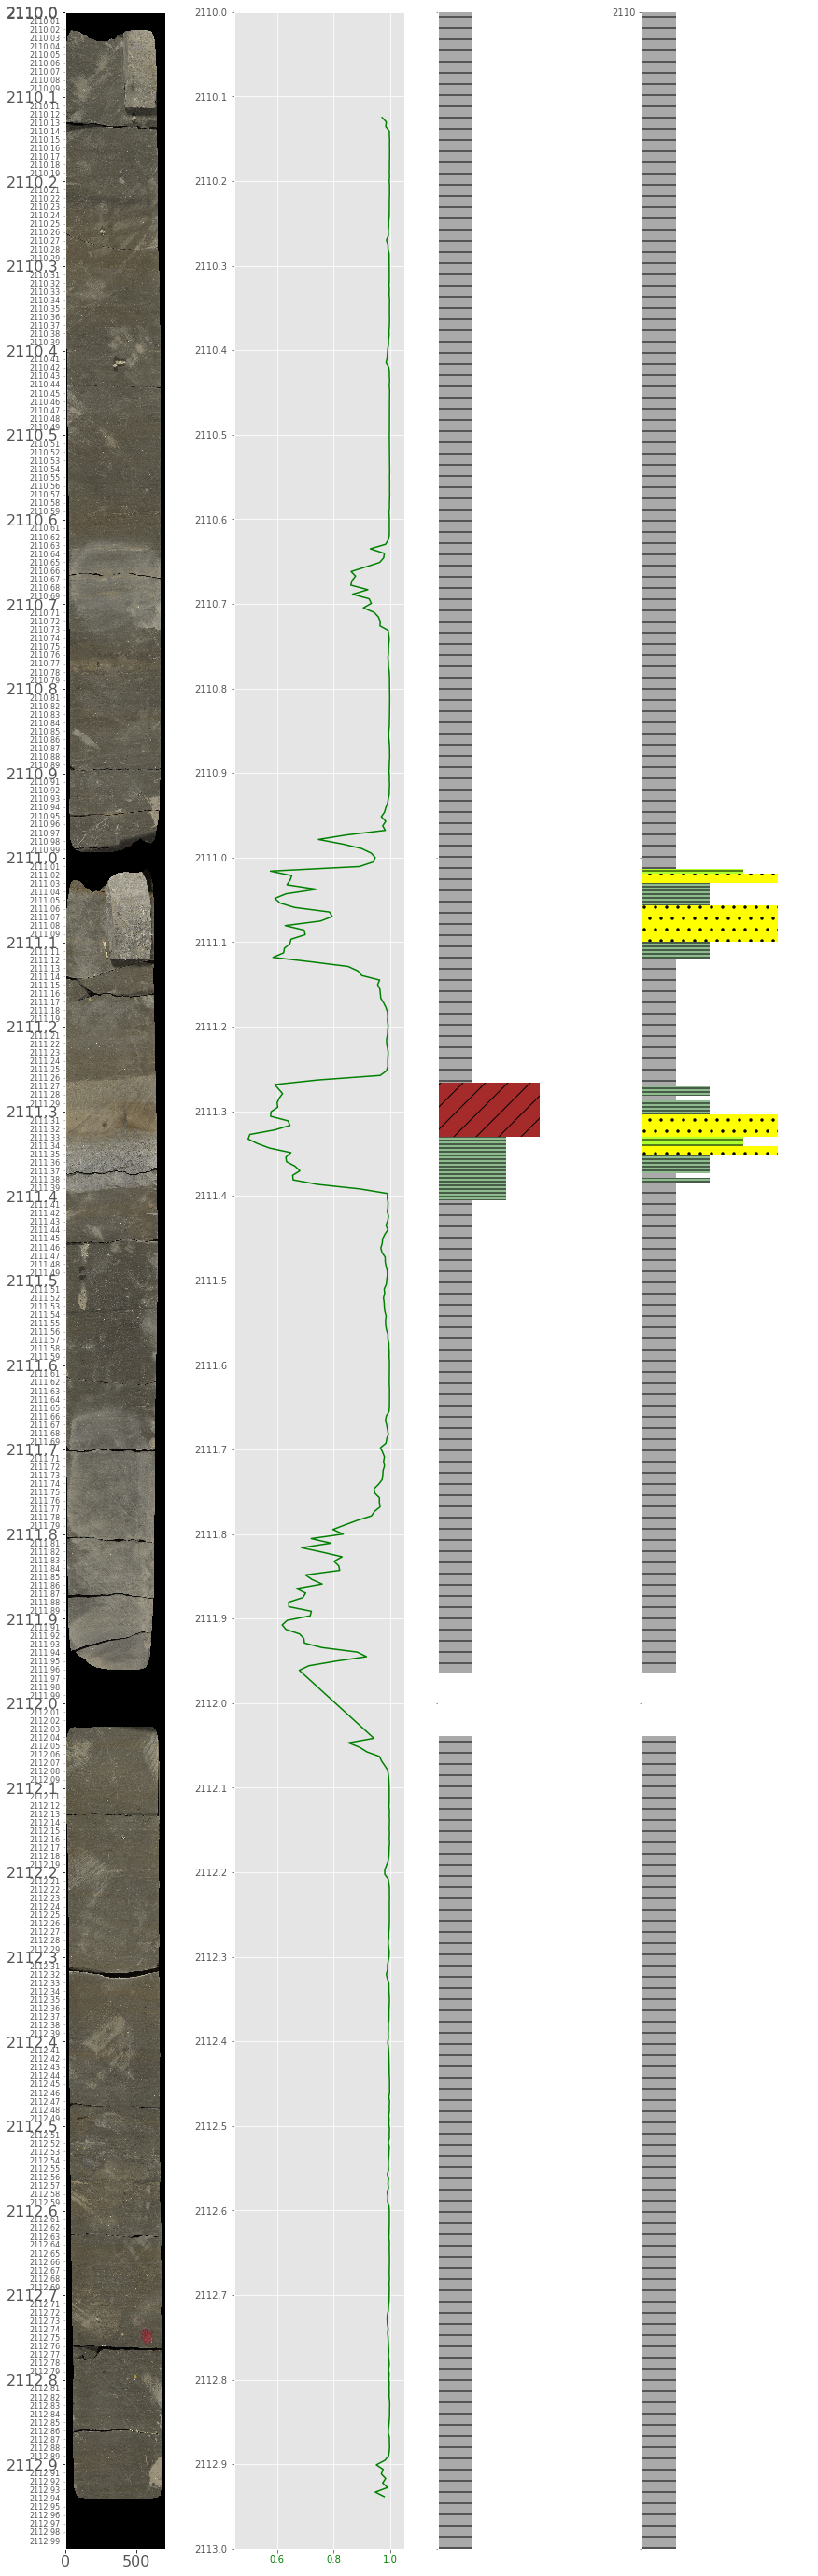

In [89]:
cplotter = viz.CorePlotter(figsize=(15, 50))

cplotter.plot_image(img, depths, **img_kwargs)

# Can also pass 'color', 'fmt' (matplotlib style, e.g., 'b--'), and `matplotlib.plot()' kwargs
cplotter.plot_log(sliced_df.depth.values, sliced_df.confidence.values, color='green', name='Confidence')

# Get striplogs from dataframe classes
true_strip = df_to_striplog(sliced_df, 2110, 2113, which='true')
pred_strip = df_to_striplog(sliced_df, 2110, 2113, which='pred')

cplotter.plot_strip(true_strip, name='True')
cplotter.plot_strip(pred_strip, name='Pred')

# Get ax by name and remove ticks
cplotter.get_ax_by_name('True').set_yticks([])

cplotter.fig.show()